In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, 
    precision_score,
    recall_score,
    f1_score,
    auc, 
    classification_report, 
    plot_confusion_matrix, 
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt  
import seaborn as sns

In [2]:
data_folder = 'dataset'

In [3]:
# load data
train_df = pd.read_csv(data_folder+"/training.csv")
test_df = pd.read_csv(data_folder+"/testing.csv")

In [4]:
# scaling Amount
train_df['Amount'] = (train_df['Amount'] - train_df['Amount'].mean())/train_df['Amount'].std()
test_df['Amount'] = (test_df['Amount'] - test_df['Amount'].mean())/test_df['Amount'].std()

In [5]:
train_df['Class'].sum()

398

### Before oversmapling

In [6]:
# separate x and y
x_train, y_train = train_df.iloc[:,:19], train_df.iloc[:,19]
x_test, y_test = test_df.iloc[:,:19], test_df.iloc[:,19] 

In [7]:
print(y_train[y_train==0].shape[0])
print(y_train[y_train==1].shape[0])

224770
398


In [8]:
# Fine best parameters using grid search
logReg = LogisticRegression()
grid={"C":np.logspace(-3,3,7)}
logreg_cv=GridSearchCV(logReg,grid,scoring='f1')
logreg_cv.fit(x_train,y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='f1')

In [9]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("f1 score : %.3f"%logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0}
f1 score : 0.756


In [10]:
# build model using best parameter and train model
logReg = LogisticRegression(solver='lbfgs', C=1, penalty='l2')
logReg.fit(x_train, y_train)

LogisticRegression(C=1)

In [11]:
# predicted class on test set
preds = logReg.predict(x_test)
# predicted probabiltiy on test set
preds_prob = logReg.predict_proba(x_test)

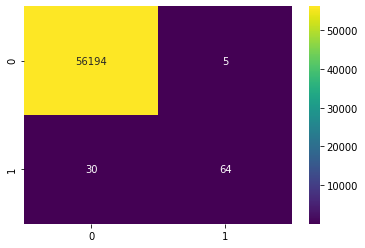

In [12]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, preds),annot=True,fmt='d',cmap='viridis')
plt.show()

In [13]:
# precision score
precision = precision_score(y_test, preds)
# recall score
recall = recall_score(y_test, preds)
# f1 score
f1= f1_score(y_test, preds)
print('Precision Score=%.3f\nRecall Score=%.3f\nF1 Score=%.3f' % (precision,recall,f1))

Precision Score=0.928
Recall Score=0.681
F1 Score=0.785


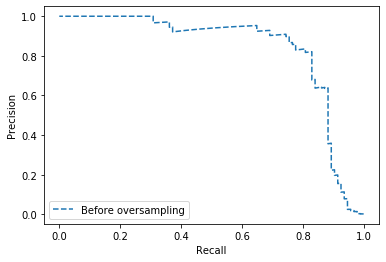

In [14]:
# Precision-recall curve
LR_precision,LR_recall,thresholds = precision_recall_curve(y_test,preds_prob[:,1])
plt.plot(LR_recall,LR_precision,linestyle='--',label='Before oversampling')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [15]:
# auc
pr_auc = auc(LR_recall,LR_precision)
print('AUC=%.3f' % (pr_auc))

AUC=0.837


In [16]:
# threshold moving
# Finetuning the decision threshold
from numpy import argmax
fscore = (2 * LR_precision * LR_recall) / (LR_precision + LR_recall)
# locate the index of the largest f1 score
ix = argmax(fscore)
print('Best Threshold=%.3f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], fscore[ix],LR_precision[ix],LR_recall[ix]))

Best Threshold=0.109, F-Score=0.825, Precision=0.821, Recall=0.830


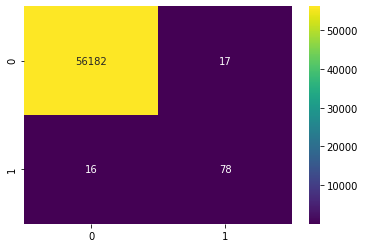

In [17]:
# new confusion matrix for threshold[ix]
preds_new = [1 if proba >= thresholds[ix] else 0 for proba in preds_prob[:,1]]
sns.heatmap(confusion_matrix(y_test,preds_new),annot=True,fmt='d',cmap='viridis')
plt.show()

### Oversampling using SMOTE

In [18]:
sm = SMOTE(sampling_strategy=0.2,random_state=0)
steps = [('o',sm)]
pipeline = Pipeline(steps=steps)
x_smote, y_smote = pipeline.fit_resample(x_train, y_train)

In [19]:
print(y_smote[y_smote==0].shape[0])
print(y_smote[y_smote==1].shape[0])

224770
44954


In [20]:
# train model
logregSmote = LogisticRegression(solver='lbfgs', C=1,penalty='l2',random_state=0)
logregSmote.fit(x_smote, y_smote)

LogisticRegression(C=1, random_state=0)

In [21]:
# predicted class on test set
preds_smote = logregSmote.predict(x_test)
# predicted probability on test set
preds_prob_smote = logregSmote.predict_proba(x_test)

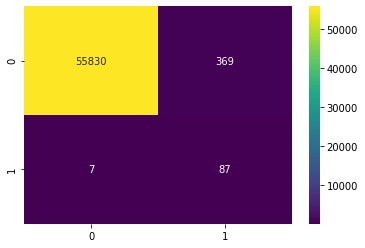

In [22]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, preds_smote),annot=True,fmt='d',cmap='viridis')
plt.show()

In [23]:
# precision score
precision = precision_score(y_test, preds_smote)
# recall score
recall = recall_score(y_test, preds_smote)
# f1 score
f1= f1_score(y_test, preds_smote)
print('Precision Score=%.3f\nRecall Score=%.3f\nF1 Score=%.3f' % (precision,recall,f1))

Precision Score=0.191
Recall Score=0.926
F1 Score=0.316


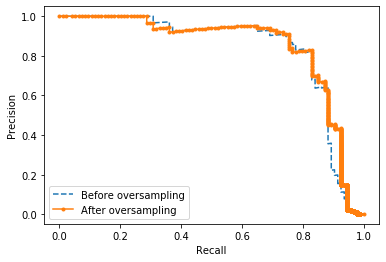

In [24]:
# precision-recall curve
LR_precision_smote, LR_recall_smote, thresholds_smote = precision_recall_curve(y_test, preds_prob_smote[:,1])
plt.plot(LR_recall,LR_precision,linestyle='--',label='Before oversampling')
plt.plot(LR_recall_smote,LR_precision_smote,marker='.',label='After oversampling')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [25]:
# auc
print("auc score: %.3f "%auc(LR_recall_smote, LR_precision_smote))

auc score: 0.846 


In [26]:
# threshold moving
# Finetuning the decision threshold
fscore_smote = (2 * LR_precision_smote * LR_recall_smote) / (LR_precision_smote + LR_recall_smote)
# locate the index of the largest f1 score
ix = argmax(fscore_smote)
print('Best Threshold=%.3f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_smote[ix], fscore_smote[ix],LR_precision_smote[ix],LR_recall_smote[ix]))

Best Threshold=0.985, F-Score=0.830, Precision=0.830, Recall=0.830


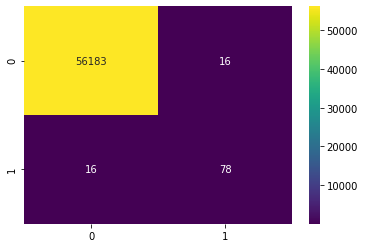

In [27]:
# new confusion matrix for threshold[ix]
preds_smote_new = [1 if proba >= thresholds_smote[ix] else 0 for proba in preds_prob_smote[:,1]]
sns.heatmap(confusion_matrix(y_test,preds_smote_new),annot=True,fmt='d',cmap='viridis')
plt.show()